# **Image Segmentation**


---


##**Task: Colon Image Segmentation**


---


##**Objective**
###1.    Utilize Transfer learning to train the model faster
###2.	Train and validate the model on 2D images (converted from 3D)
###3.	Demonstrate by inferencing on both 2D images and 3D images.
###4.	Keep the latency of the model (forward pass) less than 250ms on the GPU provided on Colab


---



---













# Installing Libraries 

In [ ]:
! pip install nibabel
! pip install segmentation_models
! pip install keras==2.3.1
! pip install visvis
! pip install trimesh

# Importing Libraries

In [ ]:
import keras
import segmentation_models as sm
sm.set_framework('tf.keras')
from skimage.measure import marching_cubes_lewiner

In [ ]:
import os, glob
import nibabel as nib
import numpy as np
from skimage.measure import marching_cubes_lewiner
import trimesh
import matplotlib.pyplot as plt
import cv2
import requests
import tarfile
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator 
import time

# Extracting data from  Tar file

In [ ]:
my_tar = tarfile.open('/content/drive/My Drive/Task10_Colon.tar')
my_tar.extractall('/content') # specify which folder to extract to
my_tar.close()

# image statistics

Colon Images

In [ ]:
img_colon = nib.load('/content/Task10_Colon/imagesTr/colon_001.nii.gz').get_fdata()
np.min(img_colon), np.max(img_colon), img_colon.shape, type(img_colon)

(-1024.0, 3072.0, (512, 512, 60), numpy.ndarray)

Colon mask images

In [ ]:
img_colon_mask = nib.load('/content/Task10_Colon/labelsTr/colon_001.nii.gz').get_fdata()
np.min(img_colon_mask), np.max(img_colon_mask), img_colon_mask.shape, type(img_colon_mask)

(0.0, 1.0, (512, 512, 60), numpy.ndarray)

# Visualization

 **Colon image slice from 3D array**







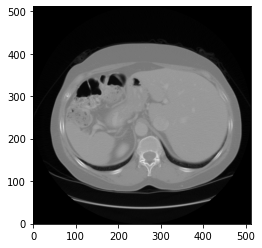

In [ ]:
imgSlice = img_colon[:,:,51]
plt.imshow(imgSlice.T, cmap="gray", origin="lower")
plt.show()

**mask Colon image slice from 3D array**

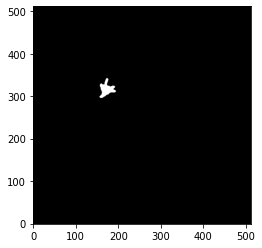

In [ ]:
imgSlice = img_colon_mask[:,:,51]
plt.imshow(imgSlice.T, cmap="gray", origin="lower")
plt.show()

# function for normalizing colon images 

Pixel values between [0,1]

In [ ]:
HOUNSFIELD_MIN = -1000
HOUNSFIELD_MAX = 3000
HOUNSFIELD_RANGE = 4000
def normalizeImageIntensityRange(img, HOUNSFIELD_MIN = -1000, HOUNSFIELD_MAX = 3000, HOUNSFIELD_RANGE = 4000):
    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX
    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE

In [ ]:
img = normalizeImageIntensityRange(img_colon)    
np.min(img), np.max(img), img.shape, type(img)

(0.0, 1.0, (512, 512, 60), numpy.ndarray)

# Creating train and test directories for saving png files of colon and colon mask images

In [ ]:
dataPath = '/content/slices3/'
dataOutputPath_train = dataPath+'training'
dataOutputPath_test = dataPath+'testing'

imageSliceOutput_train_ = os.path.join(dataOutputPath_train, 'img/')
imageSliceOutput_train = os.path.join(imageSliceOutput_train_, 'img/')

imageSliceOutput_test_ = os.path.join(dataOutputPath_test, 'img/')
imageSliceOutput_test = os.path.join(imageSliceOutput_test_, 'img/')

maskSliceOutput_train_ = os.path.join(dataOutputPath_train, 'mask/')
maskSliceOutput_train = os.path.join(maskSliceOutput_train_, 'img/')

maskSliceOutput_test_ = os.path.join(dataOutputPath_test, 'mask/')
maskSliceOutput_test = os.path.join(maskSliceOutput_test_, 'img/')


os.mkdir(dataPath) 

os.mkdir(dataOutputPath_train) 
os.mkdir(dataOutputPath_test) 


os.mkdir(imageSliceOutput_train_) 
os.mkdir(imageSliceOutput_train) 
os.mkdir(imageSliceOutput_test_) 
os.mkdir(imageSliceOutput_test)

os.mkdir(maskSliceOutput_train_) 
os.mkdir(maskSliceOutput_train) 
os.mkdir(maskSliceOutput_test_) 
os.mkdir(maskSliceOutput_test) 


# Saving colon and colon mask images into there respective folders 

In [ ]:
nii_gzz_list = list(map(lambda x: x[31:],sorted(glob.glob("/content/Task10_Colon/labelsTr/*"))))
nii_gzz_list_train = nii_gzz_list[:114]
nii_gzz_list_test = nii_gzz_list[114:]

In [ ]:
for nii_image in nii_gzz_list_train :

  three_d_image =  nib.load('/content/Task10_Colon/imagesTr/'+nii_image).get_fdata()
  three_d_image = normalizeImageIntensityRange(three_d_image)
  three_d_mask =   nib.load('/content/Task10_Colon/labelsTr/'+nii_image).get_fdata()
  depth = three_d_mask.shape[2]

  for i in range(1,depth):
    if (three_d_mask[:,:,i].sum()>0) :
      two_d_image = three_d_image[:,:,i]
      two_d_mask  = three_d_mask[:,:,i]

      two_d_image = np.uint8(two_d_image * 255)
      two_d_mask = np.uint8(two_d_mask * 255)

      file_name_image = '/content/slices3/training/img/img/'  +nii_image[:-7]+'_'+str(i).zfill(3)+'.png'
      file_name_mask  = '/content/slices3/training/mask/img/' +nii_image[:-7]+'_'+str(i).zfill(3)+'.png'

      cv2.imwrite(file_name_image, two_d_image)
      cv2.imwrite(file_name_mask, two_d_mask)



for nii_image in nii_gzz_list_test :

  three_d_image =  nib.load('/content/Task10_Colon/imagesTr/'+nii_image).get_fdata()
  three_d_image = normalizeImageIntensityRange(three_d_image)
  three_d_mask =   nib.load('/content/Task10_Colon/labelsTr/'+nii_image).get_fdata()
  depth = three_d_mask.shape[2]

  for i in range(0,depth):
    if (three_d_mask[:,:,i].sum()>0) :
      two_d_image = three_d_image[:,:,i]
      two_d_mask  = three_d_mask[:,:,i]

      two_d_image = np.uint8(two_d_image * 255)
      two_d_mask = np.uint8(two_d_mask * 255)

      file_name_image = '/content/slices3/testing/img/img/'  +nii_image[:-7]+'_'+str(i).zfill(3)+'.png'
      file_name_mask  = '/content/slices3/testing/mask/img/' +nii_image[:-7]+'_'+str(i).zfill(3)+'.png'

      cv2.imwrite(file_name_image, two_d_image)
      cv2.imwrite(file_name_mask, two_d_mask)



# Function to create image data generator

In [ ]:
def create_segmentation_generator_train(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255,dtype=tf.uint64
#                      featurewise_center=True,
#                      featurewise_std_normalization=True,
#                      rotation_range=90
#                      width_shift_range=0.2,
#                      height_shift_range=0.2,
#                      zoom_range=0.3
                        )
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

def create_segmentation_generator_test(img_path, msk_path, BATCH_SIZE):
    data_gen_args = dict(rescale=1./255,dtype=tf.uint64)
    datagen = ImageDataGenerator(**data_gen_args)
    
    img_generator = datagen.flow_from_directory(img_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    msk_generator = datagen.flow_from_directory(msk_path, target_size=IMG_SIZE, class_mode=None, color_mode='grayscale', batch_size=BATCH_SIZE, seed=SEED)
    return zip(img_generator, msk_generator)

**creating train and test image data generator**

In [ ]:
SEED = 2
IMAGE_HEIGHT = 512
IMAGE_WIDTH  = 512
IMG_SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)

data_dir_train_image = '/content/slices3/training/img'
data_dir_train_mask  = '/content/slices3/training/mask'
BATCH_SIZE_TRAIN = 10
train_generator = create_segmentation_generator_train(data_dir_train_image, data_dir_train_mask, BATCH_SIZE_TRAIN)

data_dir_test_image = '/content/slices3/testing/img'
data_dir_test_mask  = '/content/slices3/testing/mask'
BATCH_SIZE_TEST = 10
test_generator = create_segmentation_generator_test(data_dir_test_image, data_dir_test_mask, BATCH_SIZE_TEST)

Found 1176 images belonging to 1 classes.
Found 1176 images belonging to 1 classes.
Found 108 images belonging to 1 classes.
Found 108 images belonging to 1 classes.


# Creating Model

### Defining Model Parameters

In [ ]:
NUM_TRAIN = 1176 
NUM_TEST = 108
BATCH_SIZE_TRAIN = 10
BATCH_SIZE_TEST = 10
NUM_OF_EPOCHS = 10

EPOCH_STEP_TRAIN = NUM_TRAIN // BATCH_SIZE_TRAIN
EPOCH_STEP_TEST = NUM_TEST // BATCH_SIZE_TEST

### Creating model architechture 


---

UNET with backbone of RESNET-34



In [ ]:
from segmentation_models import Unet
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense

N = 1 #channels
base_model = Unet(backbone_name='resnet34', encoder_weights='imagenet')

inp = Input(shape=(512, 512, N))
l1 = Conv2D(3, (1, 1))(inp) # map N (N==1 for our case) channels data to 3 channels
out = base_model(l1)

85524480/85521592 [==============================] - 3s 0us/step


In [ ]:
model = Model(inp, out, name=base_model.name)

In [ ]:
LR = 0.0001

# define optomizer
optim = tf.keras.optimizers.Adam(LR)
n_classes = 1
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 3)       6         
_________________________________________________________________
functional_3 (Functional)    (None, None, None, 1)     24456154  
Total params: 24,456,160
Trainable params: 24,438,810
Non-trainable params: 17,350
_________________________________________________________________


### Fit  generator and making prediction

In [ ]:
model.fit_generator(generator=train_generator, 
                    steps_per_epoch=EPOCH_STEP_TRAIN, 
                    validation_data=test_generator, 
                    validation_steps=EPOCH_STEP_TEST,
                   epochs=25)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
117/117 [==============================] - 70s 602ms/step - loss: 1.0412 - iou_score: 0.1193 - f1-score: 0.1962 - val_loss: 1.0658 - val_iou_score: 2.0396e-10 - val_f1-score: 2.0396e-10
Epoch 2/25
117/117 [==============================] - 73s 620ms/step - loss: 0.9759 - iou_score: 0.3430 - f1-score: 0.5033 - val_loss: 0.9999 - val_iou_score: 7.9532e-10 - val_f1-score: 7.9532e-10
Epoch 3/25
117/117 [==============================] - 74s 636ms/step - loss: 0.9407 - iou_score: 0.4726 - f1-score: 0.6355 - val_loss: 0.9934 - val_iou_score: 7.7971e-10 - val_f1-score: 7.7971e-10
Epoch 4/25
117/117 [==============================] - 75s 643ms/step - loss: 0.8879 - iou_score: 0.5291 - f1-score: 0.6869 - val_loss: 0.9936 - val_iou_score: 8.4207e-10 - val_f1-score: 8.4207e-10
Epoch 5/25
117/117 [==============================] - 75s 644ms/step - loss: 0.7733 - iou_score: 0.5701 - f1-score: 0.7211 - val_loss: 0

#### Visualising predictions

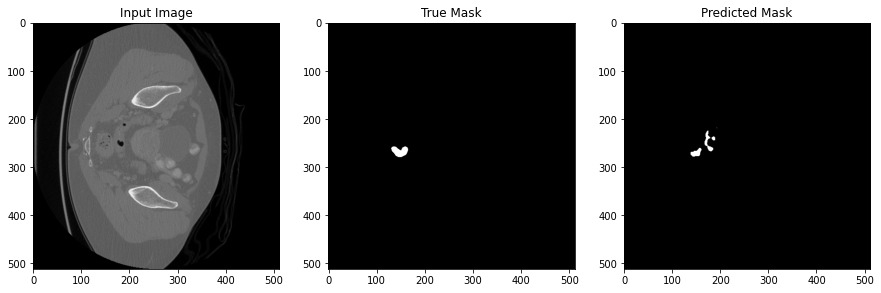

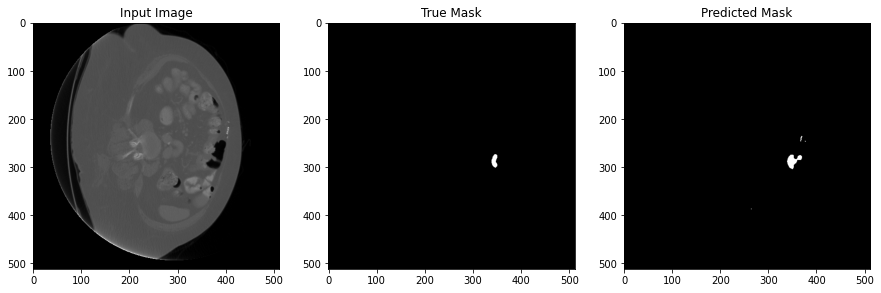

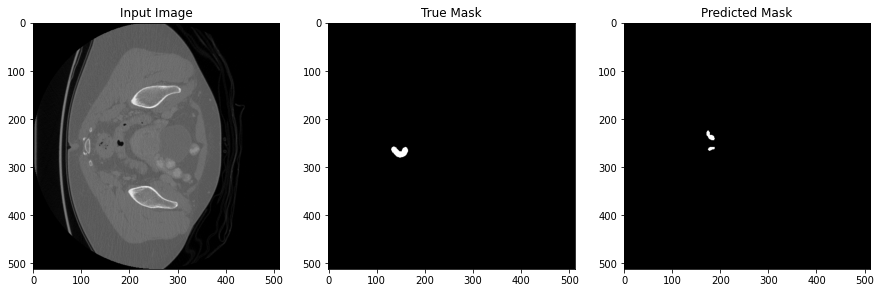

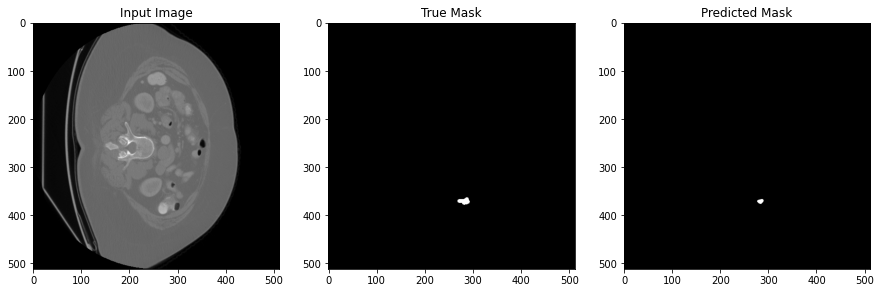

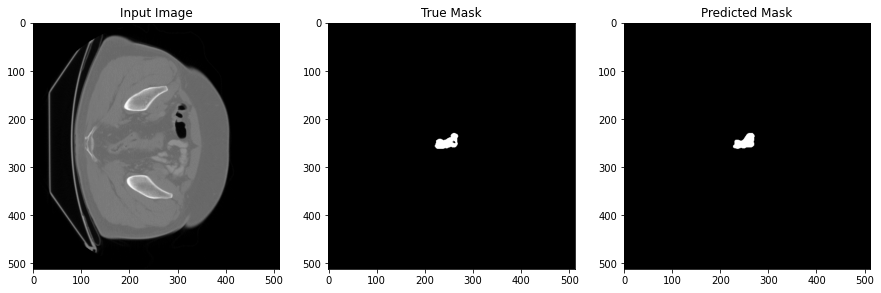

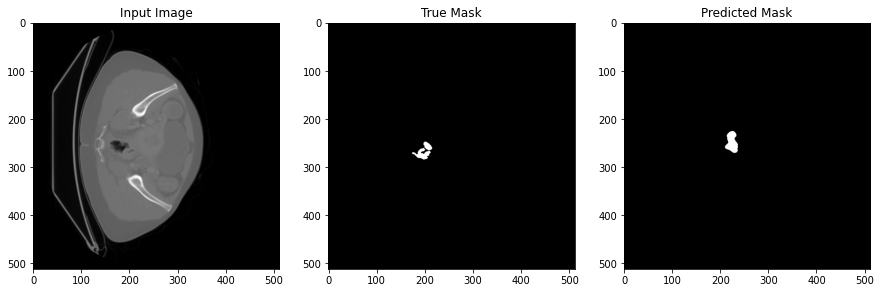

In [ ]:
def display(display_list):
    plt.figure(figsize=(15,15))
    
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap='gray')
    plt.show()

def show_dataset(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        display([image[0], mask[0]])

def show_prediction(datagen, num=1):
    for i in range(0,num):
        image,mask = next(datagen)
        pred_mask = model.predict(image)[0] > 0.05
        display([image[0], mask[0], pred_mask])

show_prediction(test_generator, 6)

# inference time calculation

**Inference time on 2D image**

In [ ]:
two_d=normalizeImageIntensityRange(nib.load('/content/Task10_Colon/imagesTr/colon_001.nii.gz').get_fdata())[:,:,51]
two_d=np.expand_dims(two_d, axis=2)
two_d=np.expand_dims(two_d, axis=0)

start_time = time.time()
_ = model.predict(two_d)

print("--- %s miliseconds for one inference on two-D image ---" % ((time.time() - start_time)*1000))

--- 66.91360473632812 miliseconds for one inference on two-D image ---


**Inference time on 3D array**

---
This is inference on 3d array with 60 2D image slices 


In [ ]:
three_d_volume = normalizeImageIntensityRange(nib.load('/content/Task10_Colon/imagesTr/colon_001.nii.gz').get_fdata())
three_d_volume = np.transpose(three_d_volume,axes=(2,0,1))
three_d_volume = np.expand_dims(three_d_volume, axis=3)
three_d_volume_predict = model.predict(three_d_volume)

start_time = time.time()
_ = model.predict(three_d_volume)
print("---  %s miliseconds for inference on 3D-volum ---" % ((time.time() - start_time)*1000))

---  983.0024242401123 miliseconds for inference on 3D-volum ---





---


---



1.   Utilised transfer learning, U-net with encoder backbone of resnet 34 with weights of imagenet
2.   Trained and validated on 2D  images
3. Made inference on 2D and 3D images
4. Forward pass takes 66.9 miliseconds


---


---




